# GLOVe-LSA-SVM
- Uses LSA to capture latent features
- Uses SVM to find optimal hyperplane of separation

---

**TODO**
- Metrics

In [12]:
## IMPORTS
# LSA
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# SVM
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
from joblib import parallel_backend

# GLOVE Embeddings
import spacy

# metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, balanced_accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
import csv
import chardet
import numpy as np
import re
import pandas as pd
import demoji

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/walnuts/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Load the dataset / read csv
# MAKE SURE CSV IS IN UTF-8 (if tweets have emojis)

## Testing if csv can open (Use for troubleshooting)
# with open('Eng_Tweets.csv') as csv_file:
#   csvFile = csv.reader(csv_file, delimiter=',')
#   for row in csv_file:
#     print(row)

pd.set_option('display.max_colwidth', None)
csv_path = 'Eng_Tweets.csv'

df = pd.read_csv(csv_path)
print("total rows: " + str(len(df)))
df.head() ## head won't show emojis unless using print function

total rows: 2335


,Username,Tweet,Date posted,Label
0,@fudaishii,i'm genuinely going to attempt tonight i can't do this anymore i can't handle all this stress i wish i was never born bro,9/11/24,1.0
1,@yourdystiny,"Becoming less reactive is a huge part of growth & decreasing stress. If you let everything get you worked up, you’ll damage your mind, body & spirit.",9/8/24,0.0
2,@ocenhxu,me ??? tired ??? stressed ??? exhausted ??? i wanna cry ??? yes.,9/8/24,1.0
3,@ifeelgoodto,"skipping meals, irregular sleeping habits, overthinking, stress, tired and drained. that's me, that's my everyday life",9/10/24,0.0
4,@ysuckme,"you deserve to be happy. not confused, not hurt, not stressed, just happy.",9/8/24,0.0


## Preprocessing
- Remove mentions (@)
- Remove hashtags (#)
- Remove URLs
- Replace emojis with textual description (Using demoji)
- Remove stop words

In [3]:
### PREPROCESSING STEPS
def clean_text(text):
  # Remove mentions
  text = re.sub(r'@[A-Za-z0-9_]+', '', text)
  # Remove hashtags
  text = re.sub(r'#\w+', '', text)
  # Remove URLs
  text = re.sub(r'http\S+|www\S+|https\S+', '', text)
  # Replace emoji with textual descriptions
  text = demoji.replace_with_desc(text)
  text = re.sub(r'(:[a-zA-Z\s]+:)', r' \1 ', text) # Add spaces around the shortcode
  text = re.sub(r'(:[a-zA-Z\s]+:)', lambda match: match.group(0).replace(' ', '_'), text)
  text = text.strip()
  return text

stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
  words = text.split()
  filtered_words = [word for word in words if word.lower() not in stop_words]
  return ' '.join(filtered_words)

df = df.dropna() # Get rid of NaN rows
df['Tweet'] = df['Tweet'].apply(clean_text)
df['Tweet'] = df['Tweet'].apply(remove_stopwords)

In [4]:
df.head()

,Username,Tweet,Date posted,Label
0,@fudaishii,i'm genuinely going attempt tonight can't anymore can't handle stress wish never born bro,9/11/24,1.0
1,@yourdystiny,"Becoming less reactive huge part growth & decreasing stress. let everything get worked up, you’ll damage mind, body & spirit.",9/8/24,0.0
2,@ocenhxu,??? tired ??? stressed ??? exhausted ??? wanna cry ??? yes.,9/8/24,1.0
3,@ifeelgoodto,"skipping meals, irregular sleeping habits, overthinking, stress, tired drained. that's me, that's everyday life",9/10/24,0.0
4,@ysuckme,"deserve happy. confused, hurt, stressed, happy.",9/8/24,0.0


In [5]:
df['Label'].value_counts()

Label
0.0    1837
1.0     496
Name: count, dtype: int64

## GloVe Embeddings
- Make sure to run "python -m spacy download en_core_web_md"
- GloVe embeddings are then averaged and standardized
- Train-Test-Validation split = 70% - 20% - 10%
- Uses undersampling to balance the training set

In [6]:
nlp = spacy.load("en_core_web_md", disable=["tagger", "parser", "ner"]) # disable non word-embedding parts of spacy

# Create an empty list to store the embeddings
embeddings = []

# Iterate through the DataFrame
for index, row in df.iterrows():
    tweet = row['Tweet']
    doc = nlp(tweet)

    # Get the embeddings for each token and store them
    tweet_embeddings = [token.vector for token in doc]
    embeddings.append(tweet_embeddings)

# Add the embeddings to the DataFrame as a new column
df['embeddings'] = embeddings

/home/walnuts/projects/tf-gpu/lib/python3.12/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [7]:
# Function to average embeddings for a tweet
def average_embeddings(embeddings_list):
    if embeddings_list:
        return np.mean(embeddings_list, axis=0)
    else:
        return np.zeros(300)  # 300 = embedding dimenstion

In [8]:
# Function to split the dataset into train, validation, and test
def split_data(df, train_size=0.7, val_size=0.1, test_size=0.2):
    # 70% into training 30% into validation + testing 
    train_df, temp_df = train_test_split(df, train_size=train_size, random_state=42)
    
    # 30% splits 10% into validation and 20% into testing
    val_df, test_df = train_test_split(temp_df, train_size=val_size / (val_size + test_size), random_state=42)
    
    return train_df, val_df, test_df

In [9]:
# Average the sentence embedding into a single entry
df['avg_embedding'] = df['embeddings'].apply(average_embeddings)

# Split the dataset
train_df, val_df, test_df = split_data(df)

X_train = np.array(train_df['avg_embedding'].to_list())
y_train = train_df['Label']
X_val = np.array(val_df['avg_embedding'].to_list())
y_val = val_df['Label']
X_test = np.array(test_df['avg_embedding'].to_list())
y_test = test_df['Label']

# # Undersample the training set to balance the classes using RandomUnderSampler
# undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
# X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Optionally, check the class distribution after undersampling
print(f"Class distribution after undersampling:\n{pd.Series(y_train_resampled).value_counts()}")

Class distribution after undersampling:
Label
0.0    1279
1.0    1279
Name: count, dtype: int64


## LSA (Latent Semantic Analysis)
- Also uses standard scaler for standardization of values

In [10]:
# Apply LSA (Latent Semantic Analysis) for dimensionality reduction
lsa = TruncatedSVD(n_components=100, random_state=42) 

X_train_lsa = lsa.fit_transform(X_train_resampled)
X_val_lsa = lsa.transform(X_val)
X_test_lsa = lsa.transform(X_test)

# Standardization (scaling)
scaler = StandardScaler()
X_train_final = scaler.fit_transform(X_train_lsa)
X_val = scaler.transform(X_val_lsa)
X_test = scaler.transform(X_test_lsa)

# X_train_final = X_train_lsa
# X_val = X_val_lsa
# X_test = X_test_lsa

## SVM (Support Vector Machine)

In [11]:
# Train the model using SVC
model = SVC(probability=True)
model.fit(X_train_final, y_train_resampled)

SVC(probability=True)

In [16]:
# Modify param_grid for linear kernel
param_grid_linear = {
    'C': [100],
    'kernel': ['linear'],  # Only linear kernel
    'class_weight': [None, 'balanced'],  # Class weight
}

# Stratified K Fold
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the SVC model
svc = SVC(probability=True)

# Define the GridSearchCV object with StratifiedKFold
grid_search_linear = GridSearchCV(
    estimator=svc,
    param_grid=param_grid_linear,
    cv=stratified_kfold,
    n_jobs=-1,
    verbose=3,
    scoring='accuracy'
)

# Fit the grid search to the training data
with parallel_backend('multiprocessing'):
    grid_search_linear.fit(X_train_final, y_train_resampled)

# Get the best parameters and best score for linear kernel
best_params_linear = grid_search_linear.best_params_
best_score_linear = grid_search_linear.best_score_

# Print the results for linear kernel
print(f"Best parameters for linear kernel: {best_params_linear}")
print(f"Best cross-validation Accuracy for linear kernel: {best_score_linear:.4f}")


Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 3/5] END C=100, class_weight=None, kernel=linear;, score=0.811 total time= 9.4min
[CV 3/5] END C=100, class_weight=balanced, kernel=linear;, score=0.811 total time= 9.4min
[CV 4/5] END C=100, class_weight=None, kernel=linear;, score=0.810 total time=10.3min
[CV 1/5] END C=100, class_weight=balanced, kernel=linear;, score=0.812 total time=10.4min
[CV 1/5] END C=100, class_weight=None, kernel=linear;, score=0.812 total time=10.5min
[CV 5/5] END C=100, class_weight=balanced, kernel=linear;, score=0.795 total time=10.7min
[CV 5/5] END C=100, class_weight=None, kernel=linear;, score=0.795 total time=11.0min
[CV 4/5] END C=100, class_weight=balanced, kernel=linear;, score=0.810 total time=11.4min
[CV 2/5] END C=100, class_weight=balanced, kernel=linear;, score=0.807 total time=11.6min
[CV 2/5] END C=100, class_weight=None, kernel=linear;, score=0.807 total time=11.6min
Best parameters for linear kernel: {'C': 100, 'class_weight'

In [36]:
# Modify param_grid for rbf kernel
param_grid_rbf = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf'],  # Only rbf kernel
    'gamma': ['scale', 'auto', 0.1, 1],  # Gamma values for RBF
    'class_weight': [None, 'balanced'],  # Class weight
}

# Define the GridSearchCV object for rbf kernel
grid_search_rbf = GridSearchCV(
    estimator=svc,
    param_grid=param_grid_rbf,
    cv=stratified_kfold,
    n_jobs=-1,
    verbose=3,
    scoring='accuracy'
)

# Fit the grid search to the training data
with parallel_backend('multiprocessing'):
    grid_search_rbf.fit(X_train_final, y_train_resampled)

# Get the best parameters and best score for rbf kernel
best_params_rbf = grid_search_rbf.best_params_
best_score_rbf = grid_search_rbf.best_score_

# Print the results for rbf kernel
print(f"Best parameters for rbf kernel: {best_params_rbf}")
print(f"Best cross-validation Accuracy for rbf kernel: {best_score_rbf:.4f}")


Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV 3/3] END C=0.1, class_weight=None, gamma=scale, kernel=rbf;, score=0.779 total time=   2.8s[CV 3/3] END C=0.1, class_weight=None, gamma=auto, kernel=rbf;, score=0.779 total time=   2.8s

[CV 1/3] END C=0.1, class_weight=None, gamma=auto, kernel=rbf;, score=0.792 total time=   2.9s
[CV 2/3] END C=0.1, class_weight=None, gamma=auto, kernel=rbf;, score=0.783 total time=   3.3s[CV 2/3] END C=0.1, class_weight=None, gamma=scale, kernel=rbf;, score=0.782 total time=   3.3s

[CV 1/3] END C=0.1, class_weight=None, gamma=0.1, kernel=rbf;, score=0.570 total time=   3.3s
[CV 1/3] END C=0.1, class_weight=None, gamma=scale, kernel=rbf;, score=0.791 total time=   3.8s
[CV 1/3] END C=0.1, class_weight=None, gamma=1, kernel=rbf;, score=0.499 total time=   3.7s[CV 2/3] END C=0.1, class_weight=None, gamma=1, kernel=rbf;, score=0.499 total time=   3.7s
[CV 3/3] END C=0.1, class_weight=None, gamma=1, kernel=rbf;, score=0.507 total time=   3.

In [41]:
# Modify param_grid for poly kernel
param_grid_poly = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['poly'],  # Only poly kernel
    'gamma': ['scale', 'auto', 0.1, 1],  # Gamma values for poly
    'degree': [3],  # Degree of the polynomial kernel (default is 3)
    'class_weight': [None, 'balanced'],  # Class weight
}

# Define the GridSearchCV object for poly kernel
grid_search_poly = GridSearchCV(
    estimator=svc,
    param_grid=param_grid_poly,
    cv=stratified_kfold,
    n_jobs=-1,
    verbose=3,
    scoring='accuracy'
)

# Fit the grid search to the training data
with parallel_backend('multiprocessing'):
    grid_search_poly.fit(X_train_final, y_train_resampled)

# Get the best parameters and best score for poly kernel
best_params_poly = grid_search_poly.best_params_
best_score_poly = grid_search_poly.best_score_

# Print the results for poly kernel
print(f"Best parameters for poly kernel: {best_params_poly}")
print(f"Best cross-validation Accuracy for poly kernel: {best_score_poly:.4f}")


Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV 2/3] END C=0.1, class_weight=None, degree=3, gamma=scale, kernel=poly;, score=0.513 total time=   1.3s
[CV 2/3] END C=0.1, class_weight=None, degree=3, gamma=auto, kernel=poly;, score=0.513 total time=   1.5s
[CV 1/3] END C=0.1, class_weight=None, degree=3, gamma=scale, kernel=poly;, score=0.536 total time=   1.6s
[CV 3/3] END C=0.1, class_weight=None, degree=3, gamma=auto, kernel=poly;, score=0.522 total time=   1.7s
[CV 1/3] END C=0.1, class_weight=None, degree=3, gamma=0.1, kernel=poly;, score=0.795 total time=   1.7s
[CV 2/3] END C=0.1, class_weight=None, degree=3, gamma=1, kernel=poly;, score=0.801 total time=   1.7s
[CV 3/3] END C=0.1, class_weight=None, degree=3, gamma=scale, kernel=poly;, score=0.521 total time=   2.1s
[CV 2/3] END C=0.1, class_weight=None, degree=3, gamma=0.1, kernel=poly;, score=0.792 total time=   2.1s
[CV 3/3] END C=0.1, class_weight=None, degree=3, gamma=0.1, kernel=poly;, score=0.805 total t

In [ ]:
# Hyperparameter search
# Define the parameter grid to search only for linear kernel hyperparameters
# param_grid = {
#     'C': [0.1, 1, 10, 100],  # Regularization parameter
#     'kernel': ['linear'],  # Only 'linear' kernel
#     'class_weight': [None, 'balanced'],  # Class weight for handling imbalanced datasets
# }

# # Initialize the StratifiedKFold cross-validation object
# stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Initialize the SVC model
# svc = SVC(probability=True)

# # Set up the GridSearchCV with StratifiedKFold cross-validation
# grid_search = GridSearchCV(
#     estimator=svc, 
#     param_grid=param_grid,  # Use the modified parameter grid
#     cv=stratified_kfold,  # Use StratifiedKFold here
#     n_jobs=-1,
#     verbose=3, 
#     scoring='accuracy'
# )

# # Fit the grid search to the training data using parallel backend
# with parallel_backend('multiprocessing'):
#     grid_search.fit(X_train_final, y_train_resampled)

# # Get the best parameters and best score
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# # Print the best results
# print(f"Best parameters found: {best_params}")
# print(f"Best cross-validation Accuracy: {best_score:.4f}")


In [ ]:
# Hyperparameter search
# Define the parameter grid to search
# param_grid = {
#     'C': [0.1, 1, 10, 100],  # Regularization parameter
#     'kernel': ['linear', 'rbf', 'poly'],  # Type of kernel
#     'gamma': ['scale', 'auto', 0.1, 1],  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
#     'class_weight': [None, 'balanced'],  # Class weight for handling imbalanced datasets
# }

# # Define a function to modify the parameter grid for 'degree' and 'solver'
# def filter_degree_and_solver(param_grid):
#     # Generate all combinations of the parameter grid
#     grid = list(ParameterGrid(param_grid))

#     # Filter out invalid combinations where 'degree' is used without 'poly' kernel
#     # Also, add solver for linear kernel
#     valid_grid = []
#     for params in grid:
#         if params['kernel'] == 'poly' and 'degree' not in params:
#             # Ensure degree is included when using 'poly' kernel
#             params['degree'] = [3]  # Default value for degree (as a list)
#         elif params['kernel'] != 'poly' and 'degree' in params:
#             # Remove degree for non-'poly' kernels
#             del params['degree']

#         # Ensure all parameters are in list format
#         for key in params:
#             if not isinstance(params[key], list):
#                 params[key] = [params[key]]

#         valid_grid.append(params)
    
#     return valid_grid

# # Filtered parameter grid based on the kernel and solver
# filtered_param_grid = filter_degree_and_solver(param_grid)

# # Initialize the StratifiedKFold cross-validation object
# stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# # Initialize the SVC model
# svc = SVC(probability=True)

# # Set up the GridSearchCV with StratifiedKFold cross-validation
# grid_search = GridSearchCV(
#     estimator=svc, 
#     param_grid=filtered_param_grid, 
#     cv=stratified_kfold,  # Use StratifiedKFold here
#     n_jobs=-1,
#     verbose=3, 
#     scoring='accuracy'
# )

# # Fit the grid search to the training data using parallel backend
# with parallel_backend('multiprocessing'):
#     grid_search.fit(X_train_final, y_train_resampled)

# # Get the best parameters and best score
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# # Print the best results
# print(f"Best parameters found: {best_params}")
# print(f"Best cross-validation Accuracy: {best_score:.4f}")


In [14]:
# Define the parameter distribution to sample from
# param_dist = {
#     'C': stats.loguniform(1e-4, 1e3),  # Uniform distribution from 0.1 to 10
#     'kernel': ['linear', 'rbf', 'poly'],  # Type of kernel
#     'gamma': ['scale', 'auto'] + list(stats.uniform(0.001, 1).rvs(10)),  # Sample gamma values from uniform distribution
#     'degree': [3, 5, 7],  # Degree for 'poly' kernel
#     'class_weight': [None, 'balanced'],  # Class weight for imbalance
# }

# # Initialize the SVC model
# svc = SVC(probability=True)

# # Set up RandomizedSearchCV with 5-fold cross-validation (number of iterations = 20)
# random_search = RandomizedSearchCV(estimator=svc, param_distributions=param_dist, n_iter=100, cv=15, n_jobs=-1, verbose=3, scoring='accuracy', random_state=42)

# # Fit the random search to the training data
# with parallel_backend('multiprocessing'):
#     random_search.fit(X_train_final, y_train_resampled)

# # Get the best parameters and best score
# best_params_random = random_search.best_params_
# best_score_random = random_search.best_score_

# print(f"Best parameters found using RandomizedSearchCV: {best_params_random}")
# print(f"Best cross-validation accuracy: {best_score_random}")


In [49]:
# Using the best parameters from grid search or random search
# best_model = grid_search.best_estimator_  # or 
# best_model = random_search.best_estimator_

# Manual plug and fit
# [CV 2/3] END C=10, class_weight=None, kernel=linear;, score=0.815 total time= 1.6min
# best_model = SVC(C=10, kernel='rbf', gamma='scale', class_weight='balanced', probability=True)
# best_model = SVC(C=10, class_weight= None, gamma= 'scale', kernel= 'rbf', probability=True) # OVERFIT
# best_model = SVC(C= 0.1, class_weight= None, degree= 3, gamma= 1, kernel= 'poly', probability=True) # OVERFIT
best_model = SVC(C=1, class_weight= None, kernel= 'linear', probability=True)
best_model.fit(X_train_final, y_train_resampled)

# Final evaluation on the test set
y_pred_test = best_model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {accuracy_test}")

Test Accuracy: 0.8008565310492506


Validation Accuracy: 0.8403755868544601
Validation Precision: 0.8098290598290598
Validation Recall: 0.8896713615023474
Validation F1 Score: 0.8478747203579419
Validation Balanced Accuracy: 0.84037558685446
Validation Confusion Matrix: 
[[337  89]
 [ 47 379]]
Test Accuracy: 0.8008565310492506
Test Precision: 0.4827586206896552
Test Recall: 0.7954545454545454
Test F1 Score: 0.6008583690987125
Test Balanced Accuracy: 0.798782681698249
Test Confusion Matrix: 
[[304  75]
 [ 18  70]]
Test ROC AUC: 0.8462461021827775


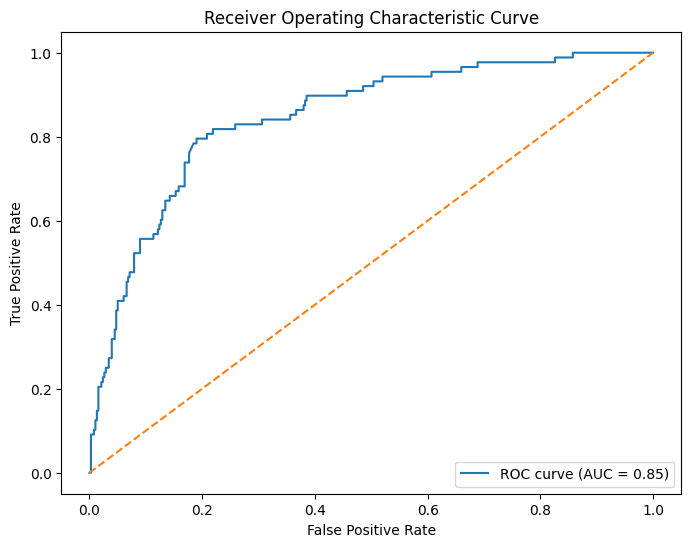

In [50]:
# Evaluation on validation set
y_pred_val = best_model.predict(X_val)
accuracy_val = accuracy_score(y_val, y_pred_val)
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1_val = f1_score(y_val, y_pred_val)
balanced_acc_val = balanced_accuracy_score(y_val, y_pred_val)  # Add balanced accuracy
conf_matrix_val = confusion_matrix(y_val, y_pred_val)

print(f"Validation Accuracy: {accuracy_val}")
print(f"Validation Precision: {precision_val}")
print(f"Validation Recall: {recall_val}")
print(f"Validation F1 Score: {f1_val}")
print(f"Validation Balanced Accuracy: {balanced_acc_val}")  # Print balanced accuracy
print(f"Validation Confusion Matrix: \n{conf_matrix_val}")

# Final evaluation on test set
y_pred_test = best_model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)
balanced_acc_test = balanced_accuracy_score(y_test, y_pred_test)  # Add balanced accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

print(f"Test Accuracy: {accuracy_test}")
print(f"Test Precision: {precision_test}")
print(f"Test Recall: {recall_test}")
print(f"Test F1 Score: {f1_test}")
print(f"Test Balanced Accuracy: {balanced_acc_test}")  # Print balanced accuracy
print(f"Test Confusion Matrix: \n{conf_matrix_test}")

# Compute ROC AUC
y_prob_test = best_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
roc_auc = roc_auc_score(y_test, y_prob_test)
print(f"Test ROC AUC: {roc_auc}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.show()

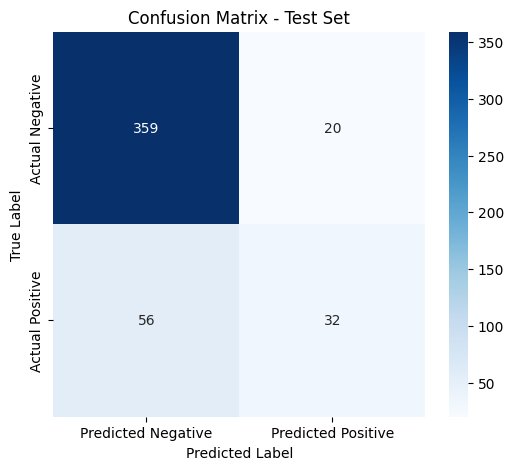

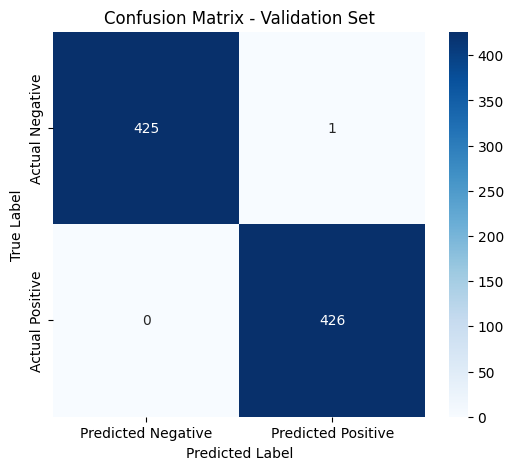

In [40]:
# Plot confusion matrix for test set
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot confusion matrix for validation set
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix - Validation Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()